In [3]:
from gdeep.topactivation import TopactivationFC as TFC
from gdeep.pipeline import Pipeline
from torch.utils.tensorboard import SummaryWriter

from gdeep.models import FFNet
from torch import nn
import torch
from gdeep.data import TorchDataLoader

In [4]:
!pip3 install xitorch
from gdeep.models import ModelExtractor
from gdeep.topactivation.spectral_analysisTorch import LaplacianOperator
import matplotlib.pyplot as plt 

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using GPU!")
else:
    DEVICE = torch.device("cpu")


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Using GPU!


In [5]:
writer = SummaryWriter()
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)

arch = [28*28, 50, 50, 10]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
loss_fn = nn.CrossEntropyLoss()
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


#cpu = torch.ones(1).device

me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())
#weights = [layer.to(cpu) for layer in weights]
lapOp = LaplacianOperator(weights)

In [6]:
u,v=lapOp.diagonalize()

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/xitorch/_utils/tensor.py:16: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1337.)
  R = torch.cholesky(VTV, upper=True)  # (*BMV, nguess, nguess)
/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/xitorch/_impls/linalg/symeig.py:174: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion

# Spectrum with no training 

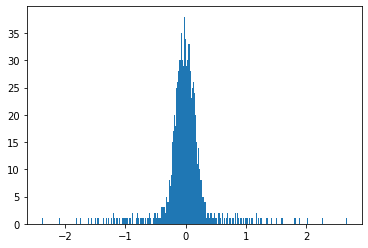

In [7]:
u = u.to('cpu')
plt.hist(u.numpy(),bins=300)
plt.show()

# Training the model 

In [8]:

optimizer = torch.optim.SGD
pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5)

Epoch 1
-------------------------------
Epoch training loss: 0.884228 	Epoch training accuracy: 76.59%                                      00 ]                     
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 89.17%,                 Avg loss: 0.384571 



(0.38457081868251164, 89.16666666666667)

# Spectrum after training 

In [9]:
me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())
#weights = [layer.to(cpu) for layer in weights]
lapOp = LaplacianOperator(weights)
uTrained,vTrained = lapOp.diagonalize()

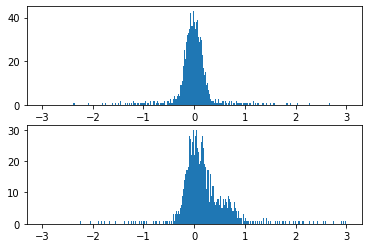

In [10]:
uTrained = uTrained.to('cpu')
plt.figure(1)
plt.subplot(211)
plt.hist(u.numpy(),bins=300,range=(-3,3))
plt.subplot(212)
plt.hist(uTrained.numpy(),bins=300,range=(-3,3))
plt.show()

# Spectrum evolution

Epoch 1
-------------------------------
Epoch training loss: 0.964838 	Epoch training accuracy: 73.45%                                      00 ]                     
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 88.20%,                 Avg loss: 0.400660 

Epoch 1
-------------------------------
Epoch training loss: 0.342688 	Epoch training accuracy: 89.98%                                      500 ]                     
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 90.88%,                 Avg loss: 0.311778 

Epoch 1
-------------------------------
Epoch training loss: 0.281586 	Epoch training accuracy: 91.91%                                      00 ]                      
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 92.36%,                 Avg loss: 0.253140 



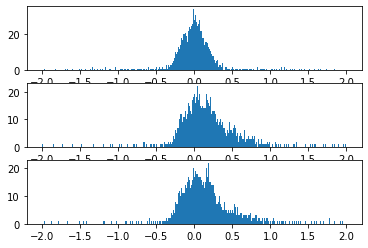

In [11]:
arch = [28*28, 50, 50, 10]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=True))
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


epochs = 2


plt.figure(1)
epochs=epochs+1
for i in range(epochs):
    #Display spectrum : 
    me = ModelExtractor(pipe.model, pipe.loss_fn)
    weights = list(me.get_layers_param().values())
    weights = [weight for weight in weights if len(weight.shape)==2]
    #weights = [layer.to(cpu) for layer in weights]
    lapOp = LaplacianOperator(weights)
    u,v = lapOp.diagonalize()
    plt.subplot(100*epochs + 11+i)
    plt.hist(u.to('cpu').numpy(),bins=300,range=(-2,2))
    #Train : 
    pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    

plt.show()

tensor(-0.0077, device='cuda:0')


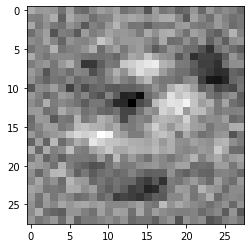

In [12]:
#Plotting eigenvectors 
idx = 6

img =-v.T[idx][:28*28].to('cpu')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')


print(u[285])

# With absolute value : 

Epoch 1
-------------------------------
Epoch training loss: 0.936907 	Epoch training accuracy: 72.63%                                      00 ]                     
Time taken for this epoch: 6.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 88.12%,                 Avg loss: 0.389926 

Epoch 1
-------------------------------
Epoch training loss: 0.346466 	Epoch training accuracy: 89.93%                                      00 ]                      
Time taken for this epoch: 6.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 91.40%,                 Avg loss: 0.301984 



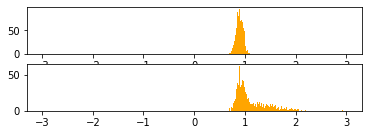

In [13]:
arch = [28*28, 50, 50, 10]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


epochs = 4

plt.figure(1)
for i in range(2):
    #Display spectrum : 
    me = ModelExtractor(pipe.model, pipe.loss_fn)
    weights = list(me.get_layers_param().values())
    #weights = [layer.to(cpu) for layer in weights]
    lapOp = LaplacianOperator(weights,positivation='abs')
    uabs,vabs = lapOp.diagonalize()
    plt.subplot(epochs*100+11+i)
    plt.hist(uabs.to('cpu').numpy(),bins=300,range=(-3,3),color='orange')
    #Train : 
    pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    

plt.show()

tensor(17.9447, device='cuda:0')


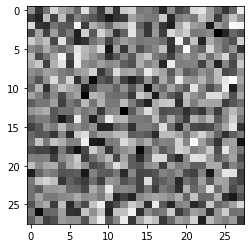

In [74]:
#Plotting eigenvectors 
idx = -8
print(uabs[idx])

img = vabs.T[idx][:28*28].to('cpu')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')



# With ReLU

Epoch 1
-------------------------------
Epoch training loss: 0.933706 	Epoch training accuracy: 73.51%                                      00 ]                     
Time taken for this epoch: 6.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 89.07%,                 Avg loss: 0.384032 

Epoch 1
-------------------------------
Epoch training loss: 0.343530 	Epoch training accuracy: 90.07%                                      00 ]                      
Time taken for this epoch: 6.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 90.46%,                 Avg loss: 0.330593 



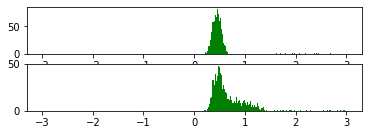

In [15]:
arch = [28*28, 50, 50, 10]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


epochs = 4

plt.figure(1)
for i in range(2):
    #Display spectrum : 
    me = ModelExtractor(pipe.model, pipe.loss_fn)
    weights = list(me.get_layers_param().values())
    weights = [weight for weight in weights if len(weight.shape)==2]
    #weights = [layer.to(cpu) for layer in weights]
    lapOp = LaplacianOperator(weights,positivation='relu')
    urelu,vrelu = lapOp.diagonalize()
    plt.subplot(epochs*100+11+i)
    plt.hist(urelu.to('cpu').numpy(),bins=300,range=(-3,3),color='green')
    #Train : 
    pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    

plt.show()

tensor(1.8118, device='cuda:0')
torch.Size([894, 893])
tensor([-0.0049,  0.0446,  0.0193,  0.0542,  0.0168,  0.0244, -0.0266,  0.0301,
         0.0516,  0.0285], device='cuda:0')


tensor(3, device='cuda:0')

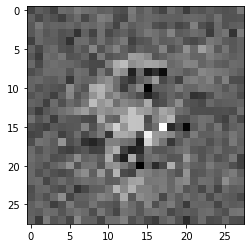

In [94]:
#Plotting eigenvectors 
idx = 789
print(urelu[idx])

img = vrelu.T[idx][:28*28].to('cpu')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')

print(vrelu.shape)
print(-vrelu.T[idx][-10:])
(-vrelu.T[idx][-10:]).argmax()

In [17]:
torch.argmax(torch.abs(vrelu.T[-5][:10]))

tensor(6, device='cuda:0')

# High spectrum tests

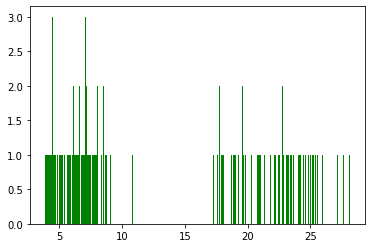

In [18]:
plt.hist(uabs.to('cpu')[28*28:].numpy(),bins=300,color='green')
plt.show()

tensor(25.6163, device='cuda:0')


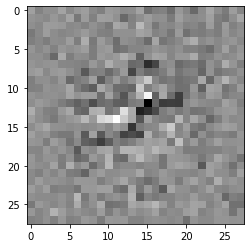

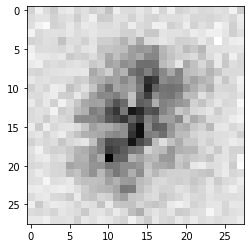

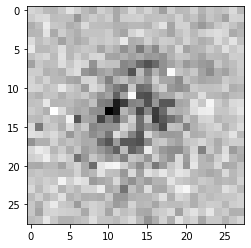

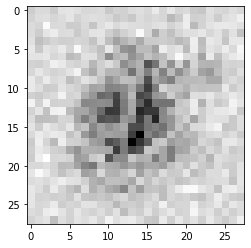

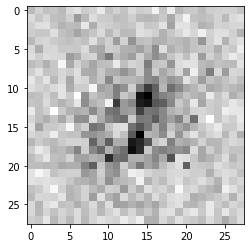

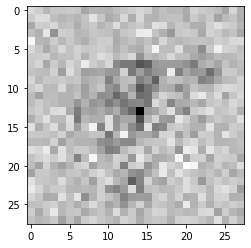

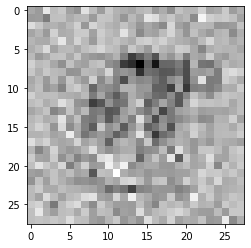

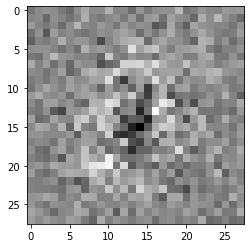

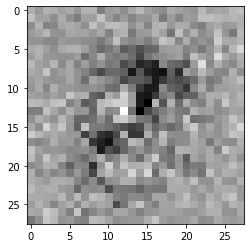

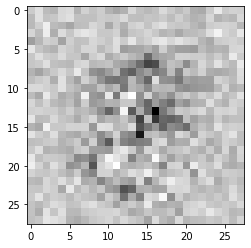

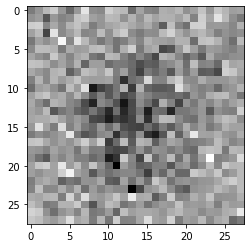

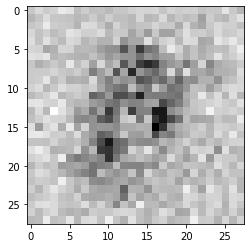

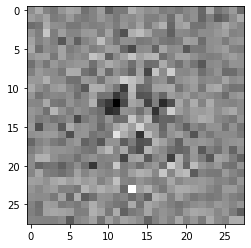

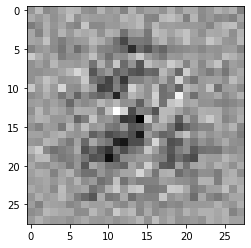

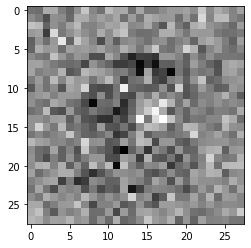

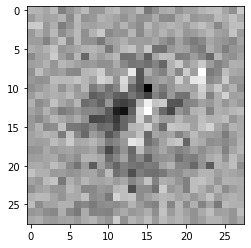

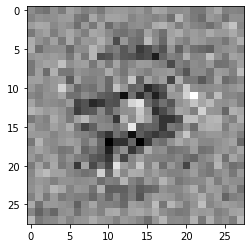

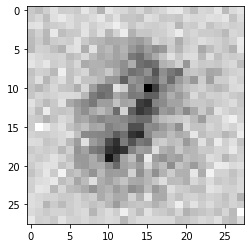

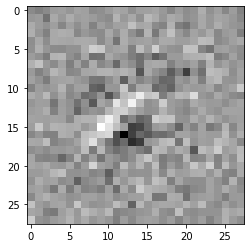

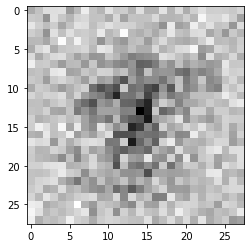

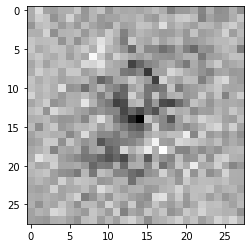

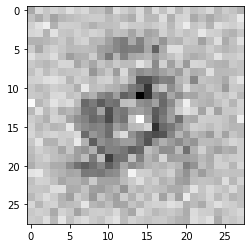

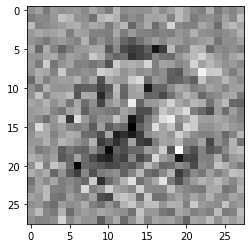

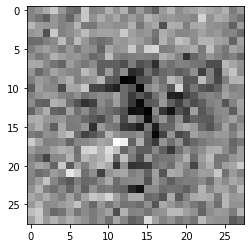

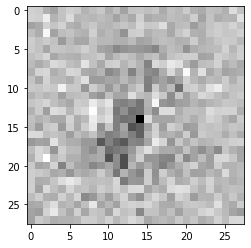

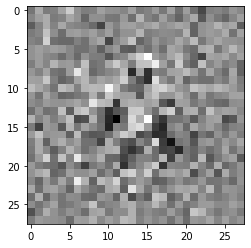

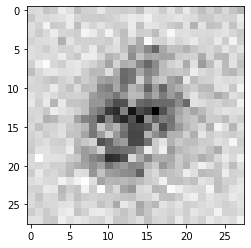

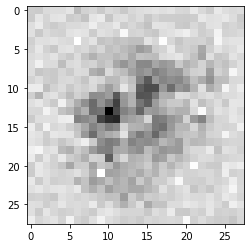

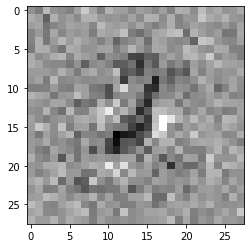

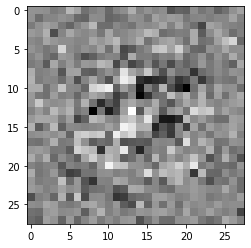

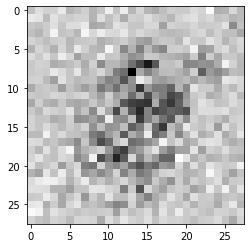

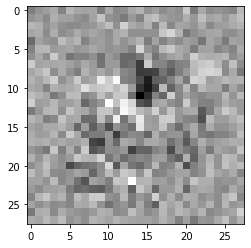

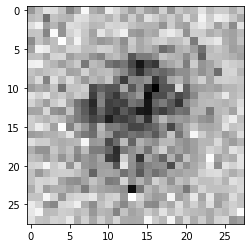

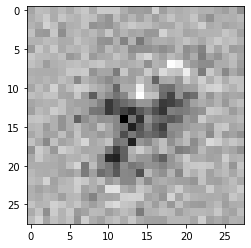

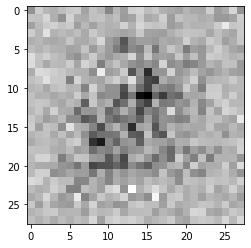

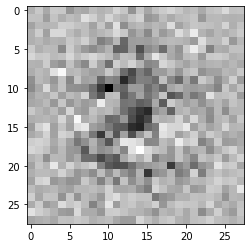

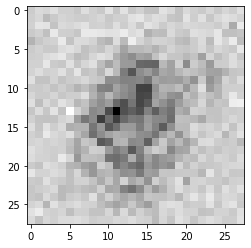

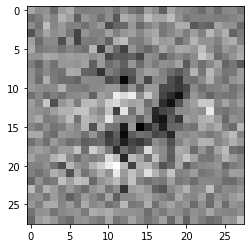

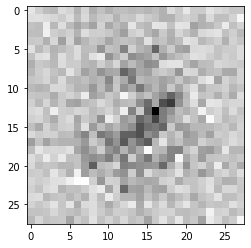

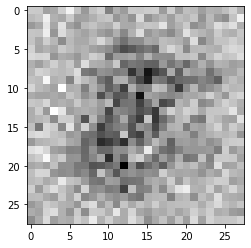

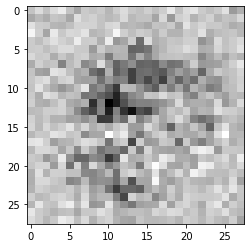

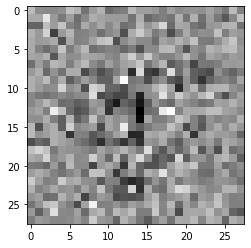

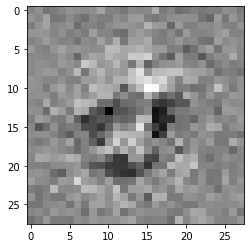

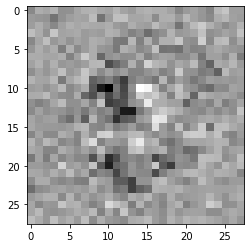

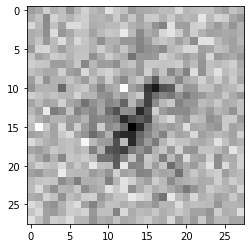

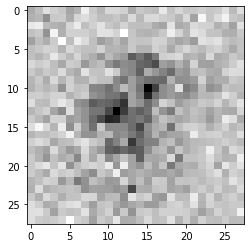

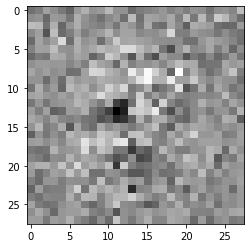

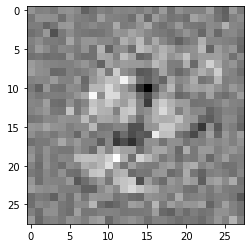

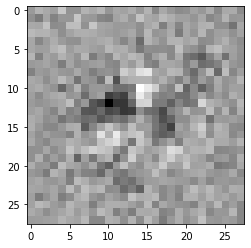

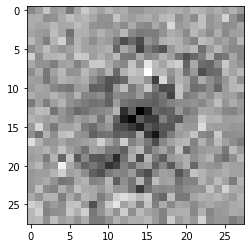

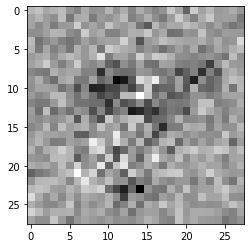

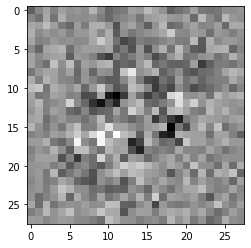

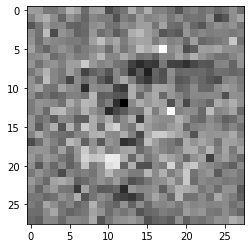

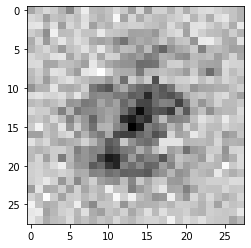

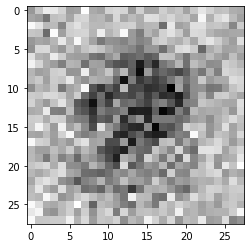

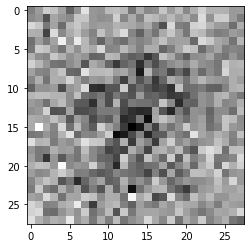

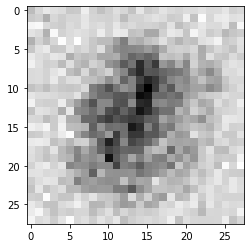

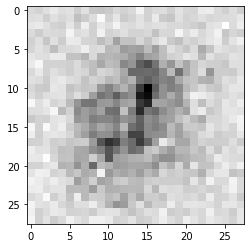

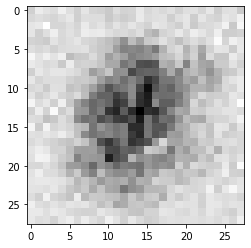

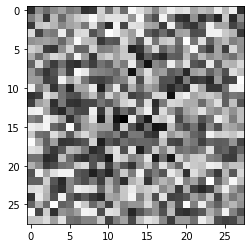

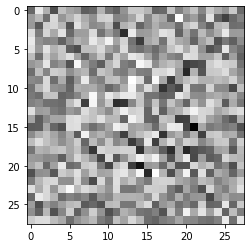

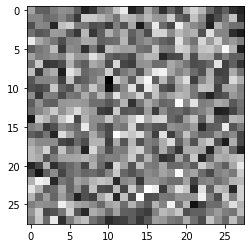

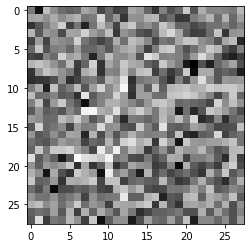

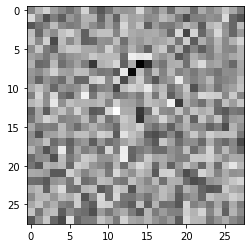

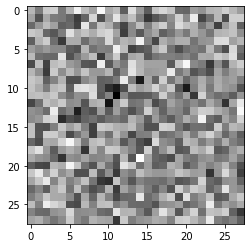

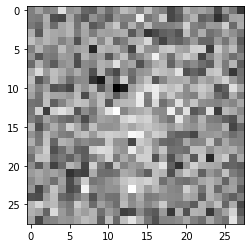

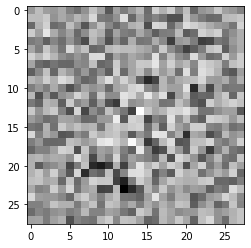

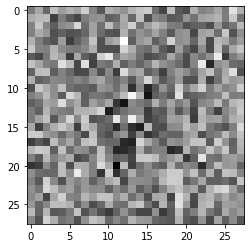

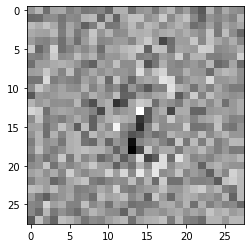

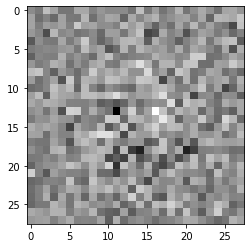

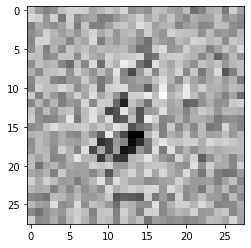

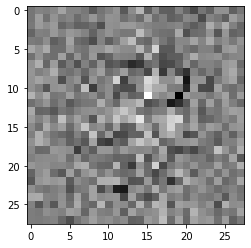

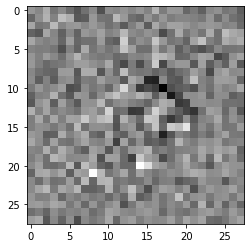

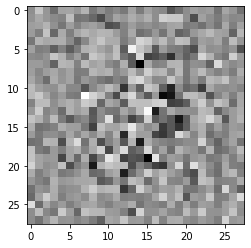

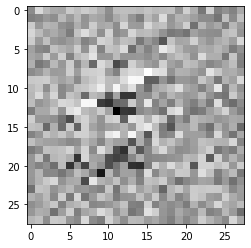

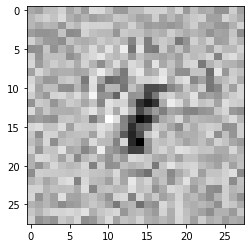

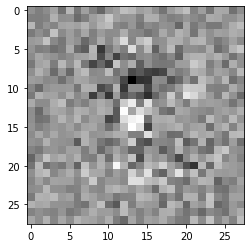

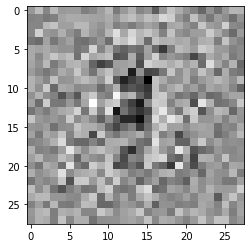

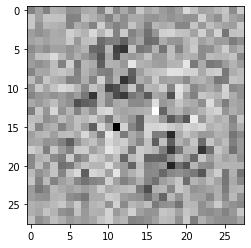

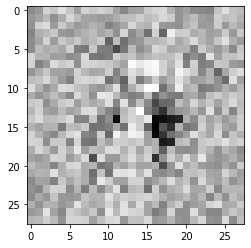

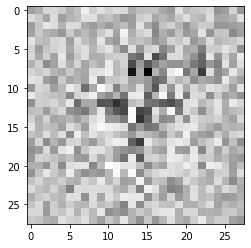

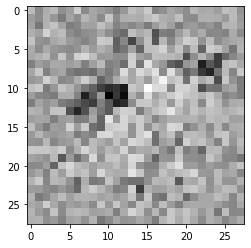

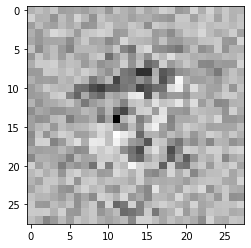

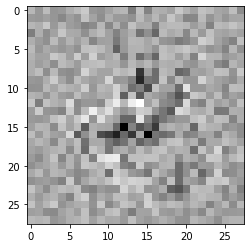

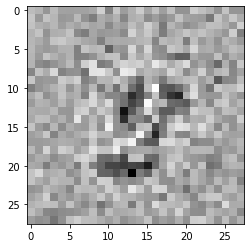

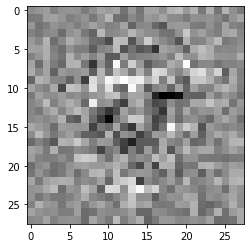

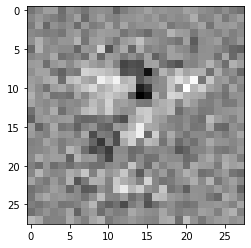

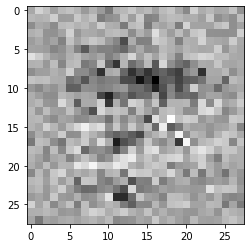

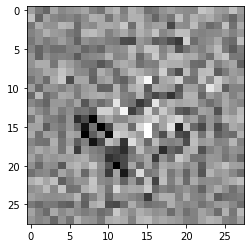

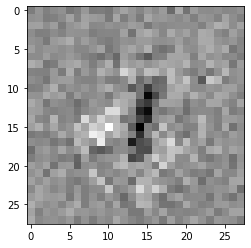

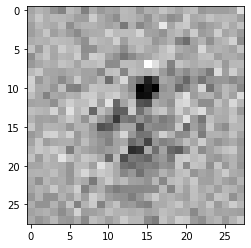

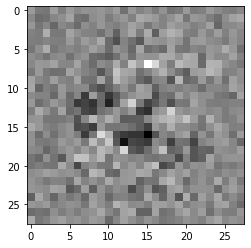

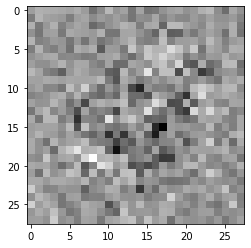

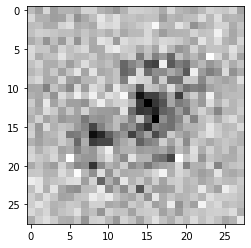

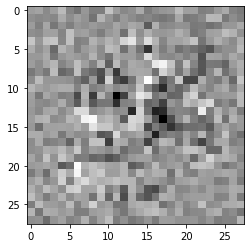

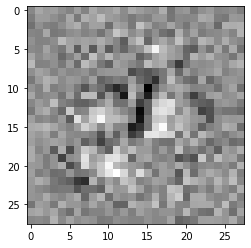

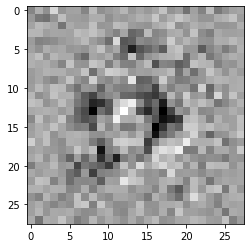

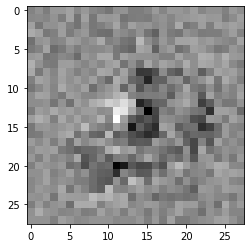

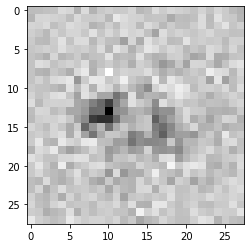

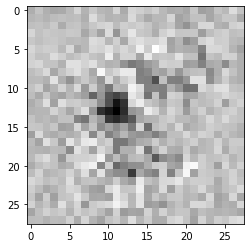

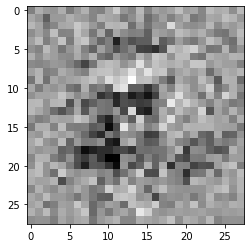

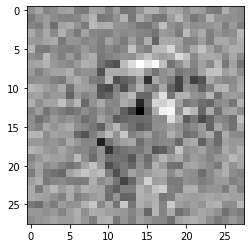

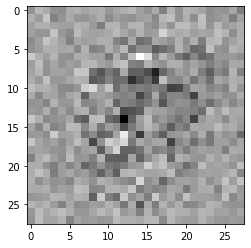

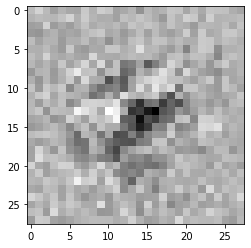

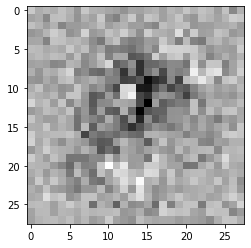

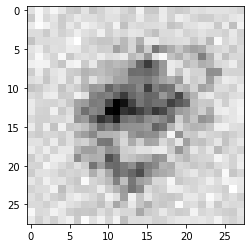

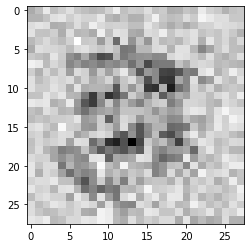

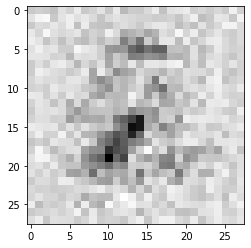

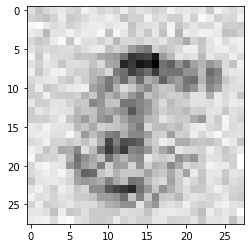

In [19]:
import time 
#Plotting eigenvectors 
idx = 888
print(uabs[idx])

i=28*28
while i <893:
    idx = i 
    if vabs.T[idx][:28*28].mean()<(vabs.T[idx][:28*28].max()+vabs.T[idx][:28*28].min())/2:
        vabs.T[idx]=-vabs.T[idx]
    img = vabs.T[idx][:28*28].to('cpu')
    pixels = img.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.savefig('lapInputLayer' + "/eigenVec%02d.png" % idx)
    plt.show()
    
    i +=1 


In [20]:
!ls

basic_tutorial_gridsearch_benchmarking.ipynb  Ensemble_learning.ipynb
basic_tutorial_image.ipynb		      Intersection_Homology.ipynb
basic_tutorial_QandA.ipynb		      lapInputLayer
basic_tutorial_regression.ipynb		      lapInputLayer.zip
basic_tutorial_tabular.ipynb		      LaplacianSpectralAnalysis.ipynb
basic_tutorial_textClass.ipynb		      optimising_topology.ipynb
basic_tutorial_translation.ipynb	      orbit_5k_train.ipynb
compactification.ipynb			      runs
data					      TopactivationFC_tutorial.ipynb
decision_boundary_tori.ipynb


# Binary mode

In [113]:
writer = SummaryWriter()
dl = TorchDataLoader(name="MNIST")

dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)

from torchvision import datasets
from gdeep.data import DataLoaderFromArray

dataset = datasets.MNIST(root='./data')
idx  = torch.logical_or(dataset.targets==4,dataset.targets==6)
targets = (dataset.targets[idx]-4)/2
data = dataset.data[idx]
j = int(len(data)*5/6) 
print(data.type())
dl2 = DataLoaderFromArray(data[:j].unsqueeze(1),targets[:j],X_val=data[j:].unsqueeze(1),y_val=targets[j:])
dl_tr2, dl_ts2,_ = dl2.build_dataloaders(batch_size=32)

for x in dl_tr2.dataset:
    x = x[0],int(x[1].item())
    
for x in dl_ts2.dataset:
    x = x[0],int(x[1].item())

print(len(dl_tr),len(dl_ts))
print(len(dl_tr2),len(dl_ts2))

torch.ByteTensor
1875 313
307 62


Epoch 1
-------------------------------


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

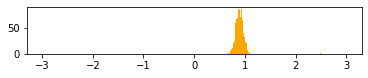

In [112]:


arch = [28*28, 50, 50, 2]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
pipe = Pipeline(model, (dl_tr2, dl_ts2), loss_fn, writer)


epochs = 4

plt.figure(1)
for i in range(2):
    #Display spectrum : 
    me = ModelExtractor(pipe.model, pipe.loss_fn)
    weights = list(me.get_layers_param().values())
    #weights = [layer.to(cpu) for layer in weights]
    lapOp = LaplacianOperator(weights,positivation='abs')
    uabs,vabs = lapOp.diagonalize()
    plt.subplot(epochs*100+11+i)
    plt.hist(uabs.to('cpu').numpy(),bins=300,range=(-3,3),color='orange')
    #Train : 
    pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    

plt.show()